[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

True

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = []
messages.append(HumanMessage(content=f"Hi, I want to learn about ocean mammals for academic research",name="Lance"))
messages.append(AIMessage(content=f"So you said you were researching ocean mammals?", name="Model"))
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

Hi, I want to learn about ocean mammals for academic research
================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message types, as discussed above.

There are [many](https://python.langchain.com/v0.2/docs/concepts/#chat-models) to choose from! Let's work with OpenAI. 

Let's check that your `OPENAI_API_KEY` is set and, if not, you will be asked to enter it.

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

We can load a chat model and invoke it with out list of messages.

We can see that the result is an `AIMessage` with specific `response_metadata`.

In [4]:
from langchain_aws import ChatBedrock   
llm = ChatBedrock(model_id="us.amazon.nova-pro-v1:0", temperature=0)
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [5]:
result

AIMessage(content="One of the best places to see orcas in the US is the waters of the Pacific Northwest, particularly around the San Juan Islands in Washington. This region is home to several resident orca populations, including the Southern Resident killer whales, which are known for their distinctive black and white coloration and complex social structures.\n\nThe best time to see orcas in this area is typically from May to September, when the whales are most active and visible. Whale-watching tours are available from several locations, including Friday Harbor, Anacortes, and Seattle. These tours offer a chance to see orcas up close and learn about their behavior, ecology, and conservation status from knowledgeable guides.\n\nIt's important to note that orcas are protected under the Marine Mammal Protection Act, and it's illegal to approach them too closely or disturb them in any way. Whale-watching tours are regulated to ensure that they are conducted in a responsible and sustainabl

In [6]:
result.response_metadata

{'ResponseMetadata': {'RequestId': 'd598044a-efc4-4e81-a693-57a3693641b2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Wed, 28 May 2025 22:47:27 GMT',
   'content-type': 'application/json',
   'content-length': '1651',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'd598044a-efc4-4e81-a693-57a3693641b2'},
  'RetryAttempts': 0},
 'stopReason': 'end_turn',
 'metrics': {'latencyMs': [3655]},
 'model_name': 'us.amazon.nova-pro-v1:0'}

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 
 
You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!
 
The `multiply` function is our tool.

In [7]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned. 

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [8]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [9]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'tooluse_GUkyp3nmSSmIfE0CUJdz_g',
  'type': 'tool_call'}]

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [10]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem! 

As we discussed, each node will return a new value for our state key `messages`.

But, this new value [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.
 
As our graph runs, we want to **append** messages to our `messages` state key.
 
We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [13]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects 
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [14]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [15]:
# Initial state
initial_messages = [
                    HumanMessage(content=f"Hi, my name is Lance",name="Lance"),
                    AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[HumanMessage(content='Hi, my name is Lance', additional_kwargs={}, response_metadata={}, name='Lance', id='db65e3c8-0038-42fb-8072-151f67ebc593'),
 AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='39e87774-c393-4ae8-9043-a822ed1cc90a'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='48d0937d-ee31-40ea-9118-761c9b2847a3'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='b2466544-4dfd-440a-81a4-2db744835247')]

## Our graph

Now, lets use `MessagesState` with a graph.

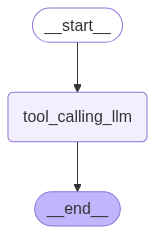

In [16]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [17]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today? If you have a mathematical problem involving multiplication, feel free to ask, and I'll do my best to help.


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [18]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

[{'type': 'text', 'text': "<thinking> The user has requested to multiply two numbers, 2 and 3. I can use the 'multiply' tool to perform this operation. </thinking>\n"}, {'type': 'tool_use', 'name': 'multiply', 'input': {'a': 2, 'b': 3}, 'id': 'tooluse_A5cWZ2YRQNSFFkidDC3Kew'}]
Tool Calls:
  multiply (tooluse_A5cWZ2YRQNSFFkidDC3Kew)
 Call ID: tooluse_A5cWZ2YRQNSFFkidDC3Kew
  Args:
    a: 2
    b: 3
